In [131]:
import struct
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm 
from matplotlib.colors import ListedColormap
from PIL import Image

def load_lut_from_file(path: str, dim: int) -> np.ndarray:
    with open(path, 'rb') as lut:
        
        
        size = [int.from_bytes(lut.read(4), 'little') for x in range(dim)]
        minmax = [(struct.unpack('f', lut.read(4))[0], struct.unpack('f', lut.read(4))[0]) for x in range(dim)]
        
        buffer = lut.read()


        print(size)
        print(minmax)

        flatarray = np.frombuffer(buffer, dtype=np.float32)
        flatarray = np.reshape(flatarray, size)

        return flatarray


FGD = load_lut_from_file("tm_FGD.bin", 4)

FGD = FGD.astype(np.float32)

FGD = np.swapaxes(FGD, 0,3)
FGD = np.swapaxes(FGD, 1,2)
FGD_resample = FGD.reshape((*FGD.shape[:3], FGD.shape[3]//2, 2))
#print(FGD_resample.shape)

FGD_resample_mean = np.mean(FGD_resample, axis=(4,))


#FGD_resample_mean = np.delete(FGD, slice(None, None, 2), 3)
print(FGD_resample_mean.shape)


newFGD = FGD_resample_mean.reshape((*FGD_resample_mean.shape[:2], FGD_resample_mean.shape[2] * FGD_resample_mean.shape[3]))

#outFGD = np.rot90(newFGD, 1, axes=(0,1))
#outFGD = np.flipud(outFGD)

outFGD = newFGD
print(newFGD.dtype)


print(newFGD.shape)

with open("tm_FGD_resample.bin", 'wb') as fbin:
    [fbin.write(int(x).to_bytes(4, 'little')) for x in outFGD.shape]
    #mins and maxes
    fbin.write(struct.pack("f", 0.0))
    fbin.write(struct.pack("f", 1.0))
    fbin.write(struct.pack("f", 0.0))
    fbin.write(struct.pack("f",1.0))
    fbin.write(struct.pack("f",0.0))
    fbin.write(struct.pack("f",4.0))
    fbin.write(struct.pack("f",0.0))
    fbin.write(struct.pack("f",4.0))
    fbin.write((outFGD.flatten('F')).tobytes('C')) #write bytes

[64, 64, 64, 64]
[(0.0, 1.0), (0.0, 1.0), (0.0, 4.0), (0.0, 4.0)]
(64, 64, 64, 32)
float32
(64, 64, 2048)


(64, 64)
0.19269407
0.0016507553
0.21271798
0.006462306


/tmp/ipykernel_446/3762995450.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gist_heat = cm.get_cmap('gist_heat', len(newFGD))


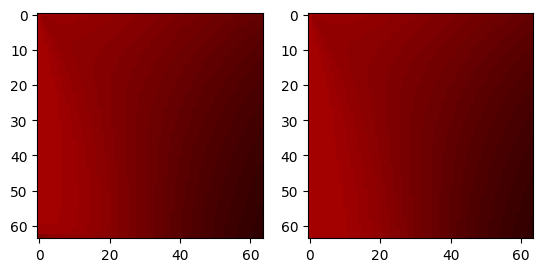

In [133]:
fig = plt.figure(1)
axes = fig.subplots(1,2)

gist_heat = cm.get_cmap('gist_heat', len(newFGD))
newColors= gist_heat(range(28))[:round(len(newFGD)/2)]
newCmap = ListedColormap(newColors)

print(newFGD[:,:,0].shape)

FGDSlice = axes[0].imshow(newFGD[:,:,32], vmin=0.0, vmax=1.0, cmap=newCmap, origin='upper')
oldslice = axes[1].imshow(FGD[:,:,0,32], vmin =0.0, vmax=1.0, cmap=newCmap, origin='upper')
print(FGD[63, 0, 15, 15])
print(FGD[63,0, 15, 1])

#outFGDtest = outFGD.reshape(64, 64, 2048)

print(outFGD[63,0, 513+7])
print(outFGD[63,0,513])


Iter 0: src: [0:262144]: 262144, dest [0: 262144]: 262144
Iter 1: src: [262144:524288]: 262144, dest [262144: 524288]: 262144
Iter 2: src: [524288:786432]: 262144, dest [524288: 786432]: 262144
Iter 3: src: [524288:786432]: 262144, dest [786432: 1048576]: 262144
Iter 4: src: [786432:1048576]: 262144, dest [1048576: 1310720]: 262144
Iter 5: src: [786432:1048576]: 262144, dest [1310720: 1572864]: 262144
Iter 6: src: [1048576:1310720]: 262144, dest [1572864: 1835008]: 262144
Iter 7: src: [1048576:1310720]: 262144, dest [1835008: 2097152]: 262144
Iter 8: src: [1310720:1572864]: 262144, dest [2097152: 2359296]: 262144
Iter 9: src: [1310720:1572864]: 262144, dest [2359296: 2621440]: 262144
Iter 10: src: [1572864:1835008]: 262144, dest [2621440: 2883584]: 262144
Iter 11: src: [1572864:1835008]: 262144, dest [2883584: 3145728]: 262144
Iter 12: src: [1835008:2097152]: 262144, dest [3145728: 3407872]: 262144
Iter 13: src: [1835008:2097152]: 262144, dest [3407872: 3670016]: 262144
Iter 14: src: [

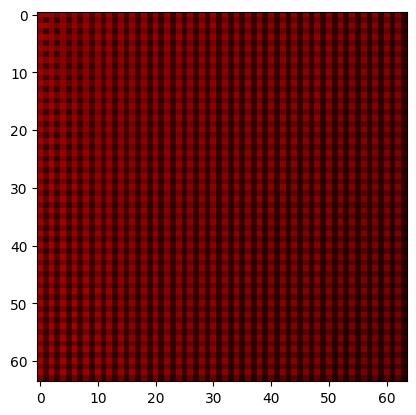

In [46]:
flatFGD = FGD.T.flatten()
stridedim = 64 * 64 * 64

new_data = np.full(flatFGD.shape[0]//2, np.nan, dtype=np.float32)
i = 0
src_index = i
end_index = i + stridedim
dest_index = i

while dest_index < new_data.size:
    print(f"Iter {i}: src: [{src_index}:{end_index}]: {end_index - src_index}, dest [{dest_index}: {dest_index +stridedim}]: {dest_index + stridedim - dest_index}")
    np.copyto(new_data[dest_index:dest_index + stridedim], flatFGD[src_index:end_index])
    if (i % 2 == 0 and i != 0):
        src_index += 0
        end_index = src_index + stridedim
    else:
        src_index += stridedim
        end_index = src_index + stridedim
    dest_index += stridedim
    i+=1

assert(not np.any(np.isnan(new_data)))

table = new_data.reshape(64,64,2048)

tablefig = plt.figure(1)
axes = tablefig.subplots(1,1)

tableslice = axes.imshow(table[:,:,32], vmin=0, vmax=1, cmap=newCmap)